# Deep Convolutional Generative Adversarial Network Example

Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## DCGAN Overview

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" alt="dcgan" style="width: 1000px;"/>

References:
- [Unsupervised representation learning with deep convolutional generative adversarial networks](https://arxiv.org/pdf/1511.06434). A Radford, L Metz, S Chintala, 2016.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). Sergey Ioffe, Christian Szegedy. 2015.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Training Params
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points

In [4]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

def residual_block(x, filters, strides, projection_shortcut=None):
    shortcut = x
    ## A residual unit
    if projection_shortcut is not None:
        shortcut = projection_shortcut(x, filters, strides)
        shortcut = tf.layers.batch_normalization(inputs=shortcut, training=is_training)

    # We halve the input at the first convolution layer
    conv1 = tf.layers.conv2d(x, filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
    conv1_batch_norm = tf.layers.batch_normalization(conv1, training=is_training)
    conv1_batch_norm_relu = leakyrelu(conv1_batch_norm)

    conv2 = tf.layers.conv2d(conv1_batch_norm_relu, filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv2_batch_norm = tf.layers.batch_normalization(conv2, training=is_training)
    conv2_batch_norm_relu = leakyrelu(conv2_batch_norm)

    return conv2_batch_norm_relu + shortcut
    #return conv2_batch_norm_relu
    ## End of the residual unit

def residual_block_transpose(x, filters, strides, projection_shortcut_residual=None):
    shortcut = x
    ## A residual unit
    if projection_shortcut_residual is not None:
        shortcut = projection_shortcut_residual(x, filters, strides)
        shortcut = tf.layers.batch_normalization(inputs=shortcut, training=is_training)

    conv1 = tf.layers.conv2d_transpose(x, filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv1_batch_norm = tf.layers.batch_normalization(conv1, training=is_training)
    conv1_batch_norm_relu = tf.nn.relu(conv1_batch_norm)

    conv2 = tf.layers.conv2d_transpose(conv1_batch_norm_relu, filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
    conv2_batch_norm = tf.layers.batch_normalization(conv2, training=is_training)
    conv2_batch_norm_relu = tf.nn.relu(conv2_batch_norm)

    return conv2_batch_norm_relu - shortcut
    #return conv2_batch_norm_relu
    ## End of the residual unit

def projection_shortcut(x, filters, strides):
    return tf.layers.conv2d(inputs=x, filters=filters, kernel_size=(1, 1), strides=strides, padding='same')

def projection_shortcut_residual(x, filters, strides):
    return tf.layers.conv2d_transpose(inputs=x, filters=filters, kernel_size=(1, 1), strides=strides, padding='same')
    

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=7 * 7 * 128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: [?x7x7x128]
        x = residual_block_transpose(x, filters=128, strides=(1,1))
        ## double the image size and halve the depths
        # image shape: [?x14x14x64]
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(1, 1), strides=(2, 2), padding='same')
        x = residual_block_transpose(x, filters=64, strides=(1,1))
        ## double the image size and halve the depths
        # image shape: [?x28x28x32]
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(1, 1), strides=(2, 2), padding='same')
        x = residual_block_transpose(x, filters=32, strides=(1,1))
        ## Make the depth back to 1
        x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same')
        # Apply tanh for better stability - clip values to [-1, 1].
        x = tf.nn.tanh(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        # INPUT: [?x28x28x1]
        x = tf.layers.conv2d(x, filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same')
        # [?x28x28x32]
        ## Start of the res-net structure
        x = residual_block(x, filters=32, strides=(1,1))
        ### halve the size
        # [?x14x14x64]
        x = tf.layers.conv2d(x, filters=64, kernel_size=(1, 1), strides=(2, 2), padding='same')
        x = residual_block(x, filters=64, strides=(1,1))
        ## halve the size
        # [?x7x7x128]
        x = tf.layers.conv2d(x, filters=128, kernel_size=(1, 1), strides=(2, 2), padding='same')
        x = residual_block(x, filters=128, strides=(1,1))
        # Flatten
        x = tf.reshape(x, shape=[-1, 7 * 7 * 128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
        return x

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [5]:
# Testing
# Generate images from noise, using the generator network.
def test_display():
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, noise_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
        # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
        g = (g + 1.) / 2.
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

Step 1: Generator Loss: 3.082777, Discriminator Loss: 1.728543


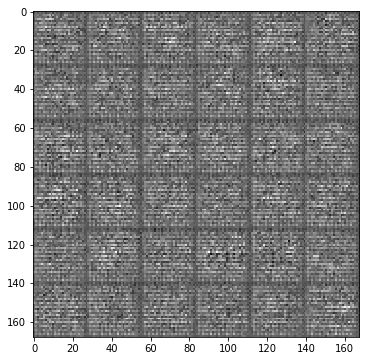

Step 100: Generator Loss: 1.763126, Discriminator Loss: 0.921798


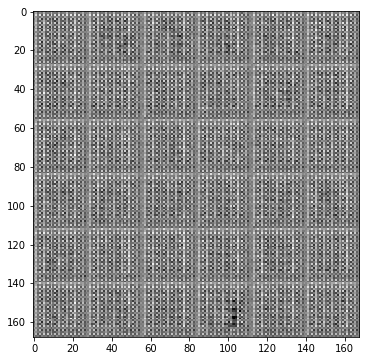

Step 200: Generator Loss: 0.930827, Discriminator Loss: 1.167174


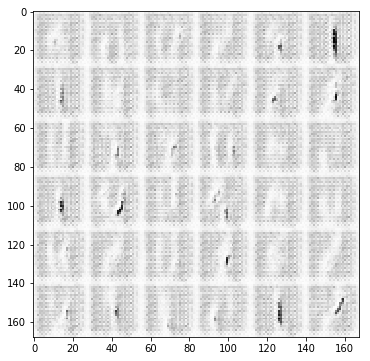

Step 300: Generator Loss: 1.377820, Discriminator Loss: 1.139828


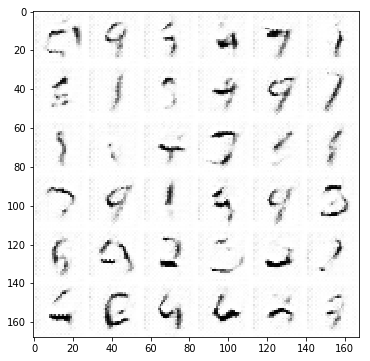

Step 400: Generator Loss: 1.239436, Discriminator Loss: 1.206305


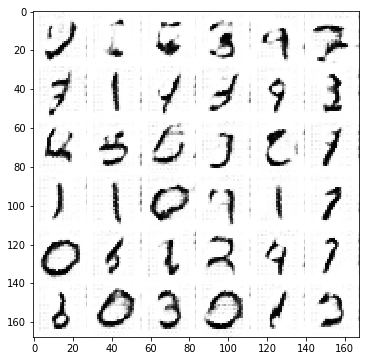

Step 500: Generator Loss: 1.243552, Discriminator Loss: 1.155045


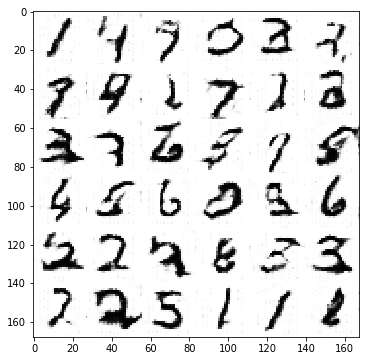

Step 600: Generator Loss: 1.214199, Discriminator Loss: 1.093486


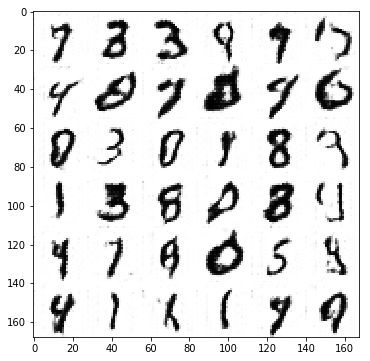

Step 700: Generator Loss: 1.203643, Discriminator Loss: 1.339010


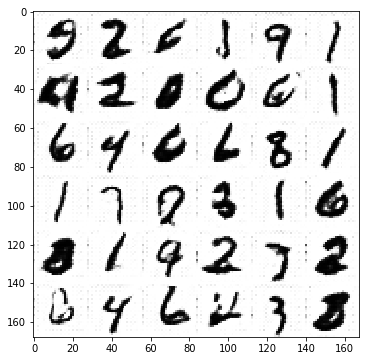

Step 800: Generator Loss: 1.169192, Discriminator Loss: 1.236492


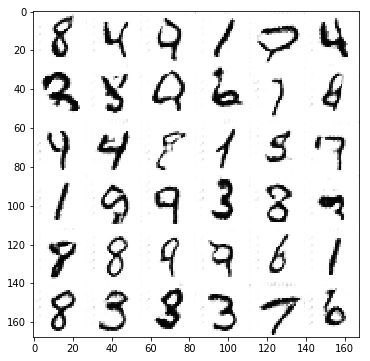

Step 900: Generator Loss: 1.119614, Discriminator Loss: 1.281000


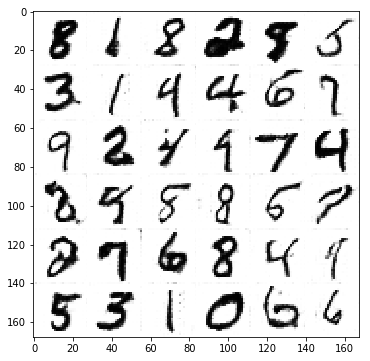

Step 1000: Generator Loss: 0.924587, Discriminator Loss: 1.069843


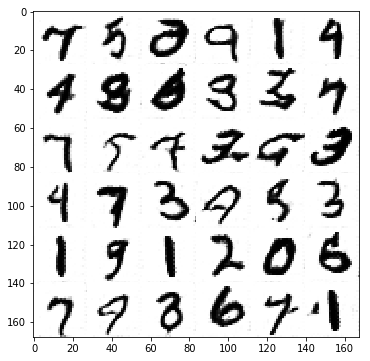

Step 1100: Generator Loss: 0.872169, Discriminator Loss: 1.199351


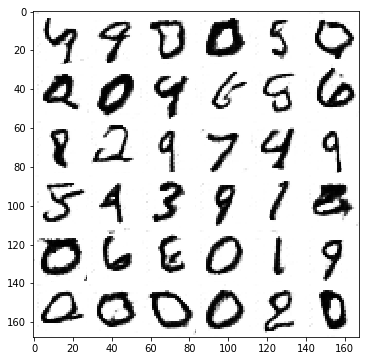

Step 1200: Generator Loss: 1.298199, Discriminator Loss: 0.984142


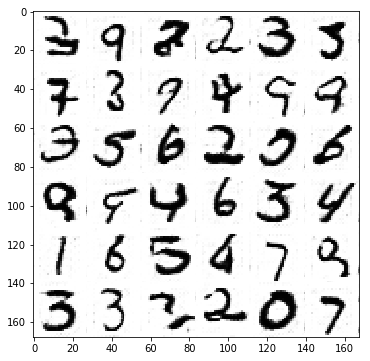

Step 1300: Generator Loss: 1.542486, Discriminator Loss: 1.173513


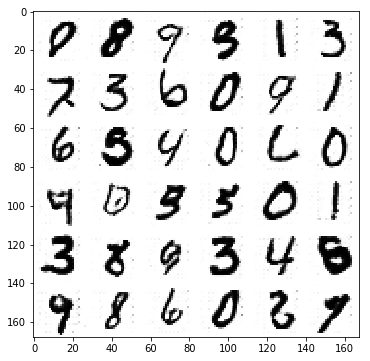

KeyboardInterrupt: 

In [6]:
# Start Training
# Start a new TF session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 100 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        test_display()

Step 1: Generator Loss: 2.894104, Discriminator Loss: 1.943751


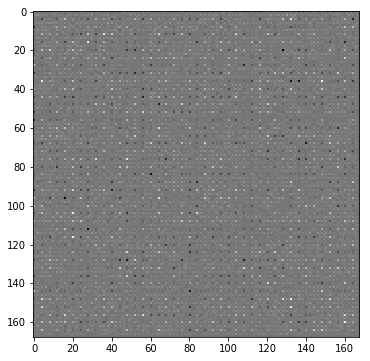

Step 100: Generator Loss: 1.371629, Discriminator Loss: 1.047625


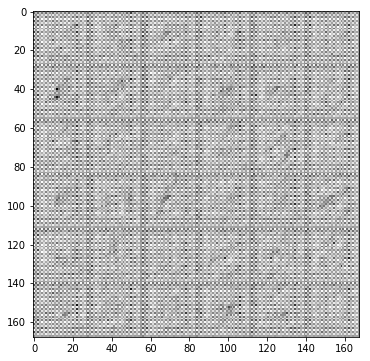

Step 200: Generator Loss: 2.073614, Discriminator Loss: 1.248847


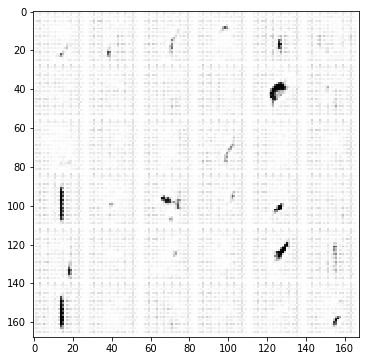

Step 300: Generator Loss: 1.260059, Discriminator Loss: 1.025873


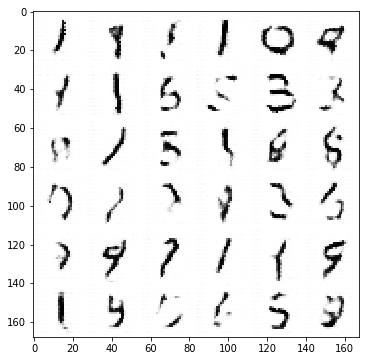

Step 400: Generator Loss: 1.384492, Discriminator Loss: 1.168002


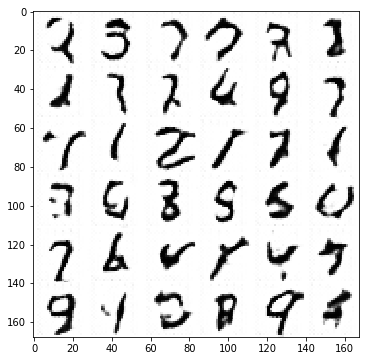

Step 500: Generator Loss: 1.589544, Discriminator Loss: 1.276515


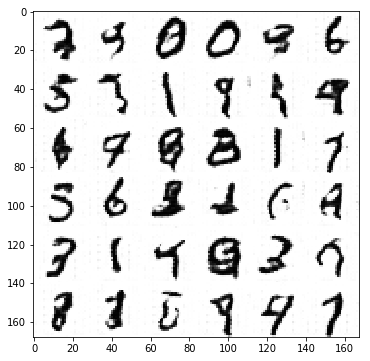

Step 600: Generator Loss: 1.349065, Discriminator Loss: 1.013566


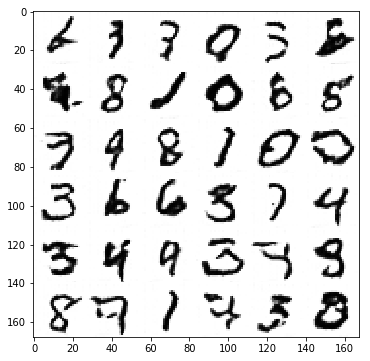

Step 700: Generator Loss: 1.221912, Discriminator Loss: 1.035847


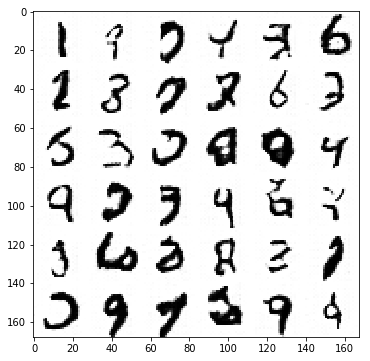

Step 800: Generator Loss: 0.942785, Discriminator Loss: 0.918167


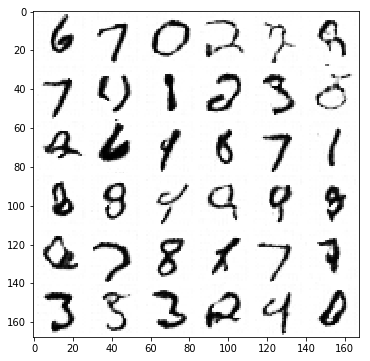

Step 900: Generator Loss: 1.231774, Discriminator Loss: 0.873297


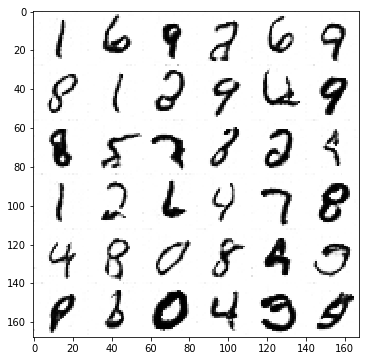

Step 1000: Generator Loss: 1.341383, Discriminator Loss: 1.034803


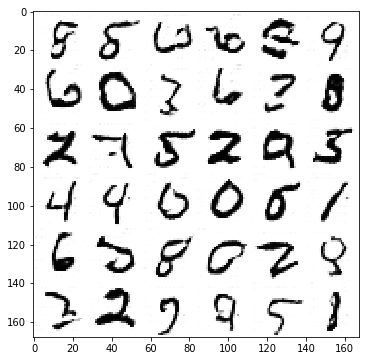

Step 1100: Generator Loss: 2.055794, Discriminator Loss: 1.490227


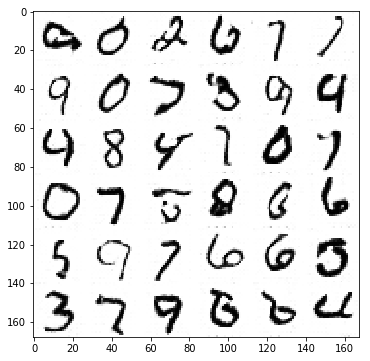

Step 1200: Generator Loss: 1.832430, Discriminator Loss: 1.349751


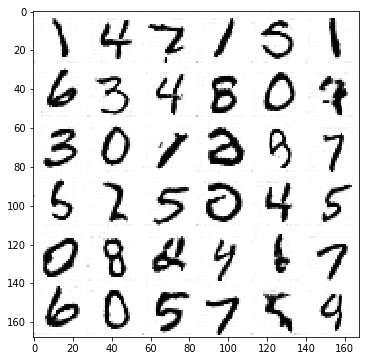

Step 1300: Generator Loss: 1.266817, Discriminator Loss: 0.971348


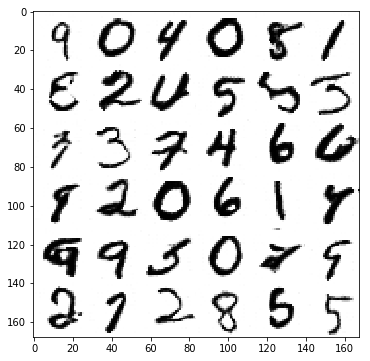

Step 1400: Generator Loss: 1.438787, Discriminator Loss: 1.173900


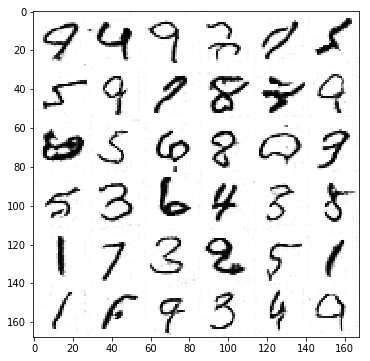

Step 1500: Generator Loss: 1.806099, Discriminator Loss: 1.274413


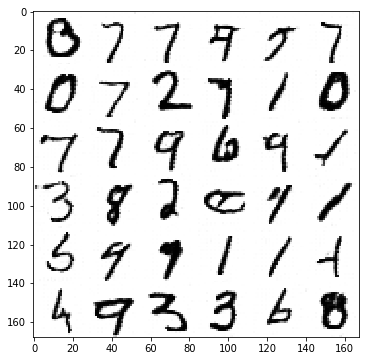

Step 1600: Generator Loss: 1.823343, Discriminator Loss: 0.805483


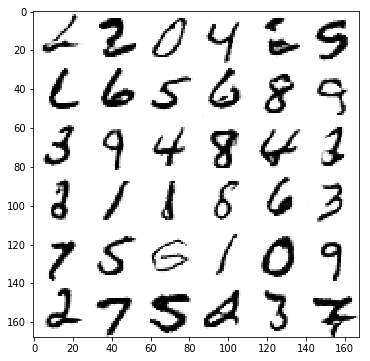

KeyboardInterrupt: 

In [6]:
# Start Training
# Start a new TF session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 100 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        test_display()